In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [335]:
def forward_predictor(data,window_width):
    """
    Calculate the forward prediction based on data. https://doi.org/10.1016/0165-0270(91)90118-J
    """
    output = np.zeros(len(data))
    output[0] = data[0] # Leere Liste wird erstellt, da wir diese nach und nach befüllen.
    for i in range(1,len(data)): # range gibt uns nach und nach die Indices [0, N-1], wo N die Länge der Daten ist. 
        if i-window_width>=0: 
            prediction = 1./window_width*np.sum(data[i-window_width:i])
        else:
            prediction = 1./i*np.sum(data[:i])
        output[i] = prediction
    return output

def predict_forward(data,window_width):
    output = np.zeros(len(data))
    output[0]=data[0]
    for i in range(1, window_width+1):
        output[i:] += data[:-i]
    
    for i in range(1,window_width):
        output[i]/=i
    output[window_width:]/=window_width
    return output

In [189]:
%timeit p1 = forward_predictor(trace,10)
%timeit p2 = forward_predictor(trace,90)
%timeit p3 = forward_predictor(trace,150)

11.6 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.2 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [342]:
%timeit forward_predictor(trace,90)

11.2 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [343]:
%timeit f1(trace,90)

423 µs ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [341]:
np.allclose(p2,p3,atol=1e-14)

True

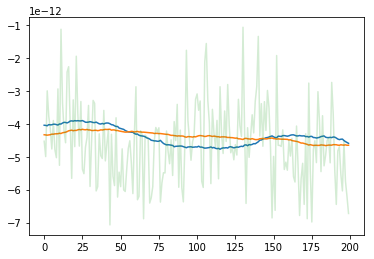

In [290]:
plt.plot(p2[1000:1200])
plt.plot(p3[1000:1200])
plt.plot(trace[1000:1200],alpha=.2)

In [303]:
x

array([-4.52894681e-12, -4.99588000e-12, -2.99996948e-12, -3.77361370e-12,
       -4.14746544e-12, -4.76546525e-12, -3.90026551e-12, -4.78530229e-12,
       -5.02945036e-12, -2.94045839e-12])

In [331]:
x = trace

In [332]:
a = f1(x,90)

In [333]:
b = forward_predictor(x,90)

True


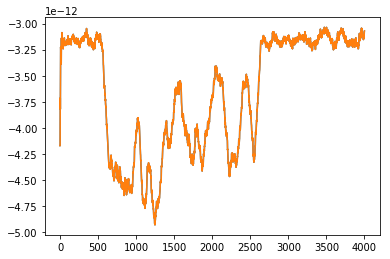

In [334]:
print(np.allclose(a,b,atol=1e-20))
plt.plot(a)
plt.plot(b)
# plt.plot(x)

In [219]:
test = np.random.normal(int(1e5))

In [220]:
%timeit for i in range(10000): np.mean(test)
%timeit for i in range(10000): np.mean(trace)

59.8 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
62.9 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [221]:
%timeit for i in range(10000): 1/1e5*np.sum(test)
%timeit for i in range(10000): 1/4e3*np.sum(trace)

34.4 ms ± 859 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.7 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [349]:
def backward_predictor(data,window_width):
    """
    Calculate the backward prediction based on data. https://doi.org/10.1016/0165-0270(91)90118-J
    """
    output = list()
    len_data = len(data)
    for i in range(len_data-1):
        if i+window_width<len_data: 
            prediction = 1/window_width*np.sum(data[i+1:i+1+window_width])
        else:
            prediction = 1/(len_data-i-1)*np.sum(data[i+1:])
        output.append(prediction)
    output.append(data[-1])
    return output
def b1(data,window_width):
    """
    Calculate the backward prediction based on data. https://doi.org/10.1016/0165-0270(91)90118-J
    """
    len_data = len(data)
    output = np.zeros(len_data)
    output[-1] = data[-1]
    for i in range(1,window_width):
        output[:-i]+=data[i:]
    
    for i in range(1,window_width):
        output[-i]/=i
    output[window_width]/=window_width
    
    return output

In [225]:
%timeit p1 = backward_predictor(trace,10)
%timeit p2 = backward_predictor(trace,90)
%timeit p3 = backward_predictor(trace,150)

11.5 ms ± 396 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.2 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 41.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [353]:
%timeit backward_predictor(trace,90)

11.3 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [354]:
%timeit b1(trace,90)

391 µs ± 4.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [352]:
np.allclose(d,f)

True

In [109]:
def calculate_forward_weights(data, M, forward_prediction, p):
    """
    Calculate the weight of the forward predictor.
    """
    #predictors should be given as lists, if the first element of forward_prediction is not a list
    #it is assumed that only a single forward prediction was given
    if type(forward_prediction[0]) is not list:
        forward_prediction=[forward_prediction]
    
    len_data = len(data)
    n_predictors = len(forward_prediction)
    #allocate weight array
    f = np.zeros((n_predictors,len_data))

    #method 1
#     for i, prediction in enumerate(forward_prediction):
#         for k in range(len_data):
#             for j in range(M):
#                 if not k-j<0:
#                     f[i,k] += (data[k-j]-prediction[k-j])**2
#             #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
#             if f[i,k]==0: f[i,k]=1
#             f[i,k] = f[i,k]**-p
            
    #method 2
    #this is same as method 1 but 40% faster
    f1 = np.zeros((n_predictors,len_data))
#     for i, prediction in enumerate(forward_prediction):
#         diff = (data-prediction)**2
#         for k in range(len_data):
#             for j in range(M):
#                 if not k-j<0:
#                     f1[i,k] += diff[k-j]
#             #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
#             if f1[i,k]==0: f1[i,k]=1
#             f1[i,k] = f1[i,k]**-p

    #method 3
    #not the same as original (though looks very similar when plotted) but also 15% slower than method 2
#     for i, prediction in enumerate(forward_prediction):
#         diff = (data-prediction)**2
#         for k in range(len_data):
#             f1[i,k] = np.sum(diff[np.max([0,k-M]):k])
#             if f1[i,k]==0: f1[i,k]=1
#             f1[i,k] = f1[i,k]**-p

    #method 4
    #from original 55ms now down to 700us and same result as method 1
#     f = np.zeros((n_predictors,len_data))
#     for i, prediction in enumerate(forward_prediction):
#         diff = (data-prediction)**2
#         for k in range(M):
#             for j in range(M):
#                 if not k-j<0:
#                     f[i,k] += diff[k-j]
#             #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
#         f[i,M:]+=diff[M:]
#         for j in range(1,M):
#             f[i,M:]+=diff[M-j:-j]
#         f[np.where(f==0)]=1
#         f = f**-p

    #method 5
    #just method 4 cleaned up a little bit, only saved about 30us
    for i, prediction in enumerate(forward_prediction):
        diff = (data-prediction)**2
        f1[i]=diff
        for j in range(1,M):
            for k in range(M):
                if not k-j<0:
                    f1[i,k] += diff[k-j]
            f1[i,M:]+=diff[M-j:-j]
        f1[np.where(f1==0)]=1
        f1 = f1**-p

    return f, f1

In [6]:
data = Recording('data/180426 000 Copy Export.mat',4e4)

In [7]:
trace = data['raw_'][20].trace

In [111]:
%timeit p1 = forward_predictor(trace,10)
%timeit p2 = forward_predictor(trace,90)
%timeit p3 = forward_predictor(trace,150)

10.8 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.5 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.8 ms ± 694 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [107]:
w, w1 = calculate_forward_weights(trace,20,[p1],2)

In [108]:
assert np.allclose(w,w1)

In [110]:
%timeit weights, w1 = calculate_forward_weights(trace,20,[p1],2)

671 µs ± 7.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [102]:
%timeit weights, w1 = calculate_forward_weights(trace,20,[p1],2)

709 µs ± 44.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


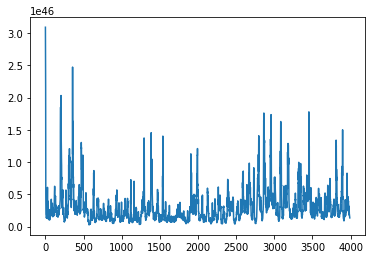

In [67]:
plt.plot(w.flatten()[10:])

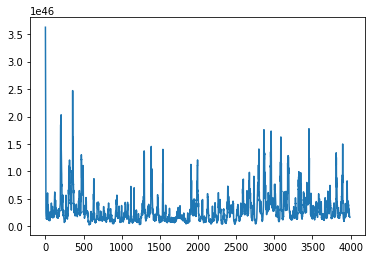

In [68]:
plt.plot(w1.flatten()[10:])

In [185]:
def calculate_backward_weights(data, M, backward_prediction, p):
    """
    Calculate the weight of the forward predictor.
    """
    #predictors should be given as lists, if the first element of backward_prediction is not a list
    #it is assumed that only a single backward prediction was given
    if type(backward_prediction[0]) is not list:
        backward_prediction=[backward_prediction]
    
    len_data = len(data)
    n_predictors = len(backward_prediction)
    #allocate weight array
    b = np.zeros((n_predictors,len_data))

    #method 1
    for i, prediction in enumerate(backward_prediction):
        for k in range(len_data):
            for j in range(M):
                if not k+j>=len_data:
                    b[i,k] += (data[k+j]-prediction[k+j])**2
            #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
        b[i, np.where(b[i]==0)]=1
        b[i] = b[i]**-p
    return b

def calculate_backward_weights1(data, M, backward_prediction, p):
    """
    Calculate the weight of the forward predictor.
    """
    #predictors should be given as lists, if the first element of backward_prediction is not a list
    #it is assumed that only a single backward prediction was given
    if type(backward_prediction[0]) is not list:
        backward_prediction=[backward_prediction]
    
    len_data = len(data)
    n_predictors = len(backward_prediction)
    #allocate weight array
    b = np.zeros((n_predictors,len_data))

    #method 1
    for i, prediction in enumerate(backward_prediction):
        diff = (data-prediction)**2
        for j in range(M):
            for k in range(len_data):
                if not k+j>=len_data:
                    b[i,k] += diff[k+j]
            #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
        b[i, np.where(b[i]==0)]=1
        b[i] = b[i]**-p
    return b

def bw1(data, M, backward_prediction, p):
    """
    Calculate the weight of the forward predictor.
    """
    #predictors should be given as lists, if the first element of backward_prediction is not a list
    #it is assumed that only a single backward prediction was given
    if type(backward_prediction[0]) is not list:
        backward_prediction=[backward_prediction]
    
    len_data = len(data)
    n_predictors = len(backward_prediction)
    #allocate weight array
    b = np.zeros((n_predictors,len_data))

    #method 2
    for i, prediction in enumerate(backward_prediction):
        diff = (data-prediction)**2
        b[i] = diff
        for j in range(1,M):
            for k in range(len_data-M,len_data):
                if not k+j>=len_data:
                    b[i,k] += diff[k+j]
        b[i,:len_data-M]+=diff[j:len_data-M+j]
        b[i, np.where(b[i]==0)]=1
        b[i] = b[i]**-p
    return b

def bw2(data, M, backward_prediction, p):
    """
    Calculate the weight of the forward predictor.
    """
    #predictors should be given as lists, if the first element of backward_prediction is not a list
    #it is assumed that only a single backward prediction was given
    if type(backward_prediction[0]) is not list:
        backward_prediction=[backward_prediction]
    
    len_data = len(data)
    n_predictors = len(backward_prediction)
    #allocate weight array
    b = np.zeros((n_predictors,len_data))

    #method 3
    for i, prediction in enumerate(backward_prediction):
        diff = (data-prediction)**2
        b[i] = diff
        for j in range(1,M):
            b[i,:-j] = b[i,:-j]+diff[j:len_data+j]
        b[i, np.where(b[i]==0)]=1
        b[i] = b[i]**-p
    return b

In [186]:
w = calculate_backward_weights(trace, 10, p, 2)
w2 = bw2(trace, 10, p, 2)
w1 = calculate_backward_weights1(trace, 10,p,2)
assert np.allclose(w,w1)
assert np.allclose(w2,w1)

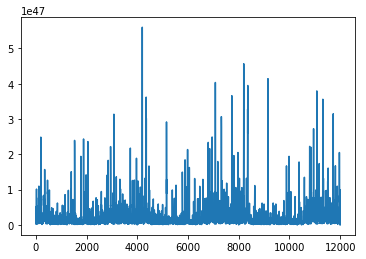

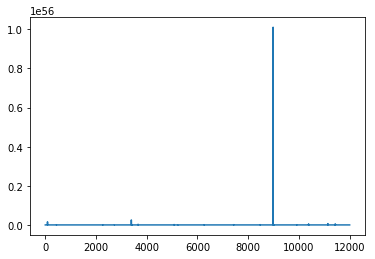

In [143]:
plt.figure()
plt.plot(w.flatten())
plt.figure()
plt.plot(w1.flatten())

In [113]:
p = []
for w in [10,50,150]:
    p.append(backward_predictor(trace,w))

In [188]:
%timeit bw2(trace, 10, p, 2)

1.63 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [145]:
%timeit calculate_backward_weights1(trace, 10, p, 2)
%timeit calculate_backward_weights1(trace, 20, p, 2)
%timeit calculate_backward_weights1(trace, 50, p, 2)
%timeit calculate_backward_weights1(trace, 10, p, 4)
%timeit calculate_backward_weights1(trace, 20, p, 4)

48.2 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
91.7 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
225 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
47.2 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
94.1 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [114]:
%timeit calculate_backward_weights(trace, 10, p, 2)
%timeit calculate_backward_weights(trace, 20, p, 2)
%timeit calculate_backward_weights(trace, 50, p, 2)
%timeit calculate_backward_weights(trace, 10, p, 4)
%timeit calculate_backward_weights(trace, 20, p, 4)
%timeit calculate_backward_weights(trace, 50, p, 4)
%timeit calculate_backward_weights(trace, 10, p, 8)
%timeit calculate_backward_weights(trace, 20, p, 8)
%timeit calculate_backward_weights(trace, 50, p, 8)

91.3 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
167 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
404 ms ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
90.6 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
170 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
452 ms ± 42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
94.6 ms ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
167 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
394 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
def test_forward_pred():
    #input
    x = np.array([1,2,3,5,6,8,10,12,14,20,10,15,2,3,5,18,14,12,14])
    #targets
    tp2 = 1/2*np.array([2,2,3,5,8,11,14,18,22,26,34,30,25,17,5,8,23,32,26])
    tp3 = 1/3*np.array([3,3,4,6,10,14,19,24,30,36,46,44,45,27,20,10,26,37,44])
    p2 = forward_predictor(x,2)
    p3 = forward_predictor(x,3)
    assert np.allclose(tp2,p2)
    assert np.allclose(tp3,p3)

In [17]:
def test_forward_pred():
    #input
    x = np.array([1,2,3,5,6,8])
    #targets
    tp2 = 1/2*np.array([2,2,3,5,8,11])
    
    tp3 = 1/3.*np.array([3,3,4,6,10,14])
    p2 = forward_predictor(x,2)
    p3 = forward_predictor(x,3)
    print(p3)
    assert np.allclose(tp2, p2)
    assert np.allclose(tp3, p3)
test_forward_pred()

[1, 1.0, 1.5, 2.0, 3.333333333333333, 4.6666666666666661]


AssertionError: 

In [24]:
def test_forward_pred():
    #input
    x = np.array([1,2,3,5,6,8,1,1,1,1,2,3,5,6,8])
    
    tp3 = 1/3.*np.array([3,3,4,6,10,14,19,15,10,3,3,4,6,10,14])

    p3 = forward_predictor(x,3)
    print(p3)
    assert np.allclose(tp3, p3)
test_forward_pred()

[1, 1.0, 1.5, 2.0, 3.333333333333333, 4.6666666666666661, 6.333333333333333, 5.0, 3.333333333333333, 1.0, 1.0, 1.3333333333333333, 2.0, 3.333333333333333, 4.6666666666666661]


AssertionError: 

In [361]:
%%javascript

IPython.tab_as_tab_everywhere = function(use_tabs) {
    if (use_tabs == undefined) {
        use_tabs = true;
    }
    IPython.notebook.get_cells().map(
    function(c) {return c.code_mirror.options.indentWithTabs=use_tabs; }
    );
    CodeMirror.defaults.indentWithTabs=use_tabs;
}
IPython.tab_as_tab_everywhere()

<IPython.core.display.Javascript object>

In [368]:
class ChungKennedyFilter:
	"""
	Create a "Chung-Kennedy" filter as described in
	https://doi.org/10.1016/0165-0270(91)90118-J
	"""
	def __init__(self, window_lengths, weight_exponent, weight_window,
				 apriori_f_weights=False, apriori_b_weights=False):
		"""
		Parameters:
			window_lengths [list of positive ints] - a python list containing
					the desired widths of the forward and backward predictors
			weight_exponent [positive float] - the exponent governing the
					sensitivity of the weights to the accuracy of the predictors
					this is 'p' in the original paper
			apriori_f_weights [list of positive floats] - apriori confidence in
					the different forward predictors, 'pi_i' in the paper
			apriori_b_weights [list of positive floats] - apriori confidence in
					the different backward predictors, 'pi_i' in the paper
		Note:
			-window_lengths used for forward and backward prediction are the
			same
			-if apriori weights are given their order is assumed to correspond
			to the order of the window lengths
		"""
		self.window_lengths = window_lengths
		self.weight_exponent = weight_exponent
		self.weight_window = weight_window
		n_predictors = len(window_lengths)

		if apriori_f_weights: self.apriori_f_weights = apriori_f_weights
		else: self.apriori_f_weights = np.ones(n_predictors)/n_predictors

		if apriori_b_weights: self.apriori_b_weights = apriori_b_weights
		else: self.apriori_b_weights = np.ones(n_predictors)/n_predictors


	def predict_forward(self, data, window_width):
		"""
		Calculate the forward prediction
		the boundary effects are handled by taking the first preddiction
		equal to the first element and then predicting on a window of increasing
		size until the full window_width is reached
		Parameters:
			data [1D array or list of floats] - the data to be filtered
			window_width [int] - the width of the prediction window
		"""
		output = np.zeros(len(data))
		output[0]=data[0]
		for i in range(1, window_width+1):
			output[i:] += data[:-i]

		for i in range(1,window_width):
			output[i]/=i
		output[window_width:]/=window_width

		return output

	def predict_backward(self,data,window_width):
		"""
		Calculate the backward prediction
		The implementation and parameters are the same as in predict_forward
		"""
		len_data = len(data)
		output = np.zeros(len_data)
		output[-1] = data[-1]
		for i in range(1,window_width):
			output[:-i]+=data[i:]

		for i in range(1,window_width):
			output[-i]/=i
		output[window_width]/=window_width

		return output

	def calculate_forward_weights(self, data, predictions):
		"""
		Calculate the weights of the forward predictors.
		Parameters:
			data [1D array or list of floats] - the data to be filtered
			predictions [list of 1D arrays] - the predictions to be weighted
		"""
		#predictors should be given as lists, if the first element of
		#predictions is not a list it is assumed that only a single forward
		#prediction was given
		if type(predictions[0]) is not np.ndarray:
		    predictions=[predictions]

		len_data = len(data)
		n_predictors = len(predictions)
		#allocate weight array
		f = np.zeros((n_predictors,len_data))
		for i, prediction in enumerate(predictions):
			diff = (data-prediction)**2
			f[i]=diff
			for j in range(1, self.weight_window):
				for k in range(self.weight_window):
					if not k-j<0:
						f[i,k] += diff[k-j]
				f[i,self.weight_window:]+=diff[self.weight_window-j:-j]
			f[:,np.where(f[i]==0)]=1
			f[i] = f[i]**-self.weight_exponent
			f[i]*=self.apriori_f_weights[i]

		return f

	def calculate_backward_weights(self, data, backward_prediction):
		"""
		Calculate the weights of the backward predictors.
		Parameters:
			data [1D array or list of floats] - the data to be filtered
			predictions [list of 1D arrays] - the predictions to be weighted
		"""
		#predictors should be given as lists, if the first element of
		#predictions is not a list it is assumed that only a single forward
		#prediction was given
		if type(backward_prediction[0]) is not np.ndarray:
		    backward_prediction=[backward_prediction]

		len_data = len(data)
		n_predictors = len(backward_prediction)
		#allocate weight array
		b = np.zeros((n_predictors,len_data))

		for i, prediction in enumerate(backward_prediction):
			diff = (data-prediction)**2
			b[i] = diff
			for j in range(1,self.weight_window):
				b[i,:-j] = b[i,:-j]+diff[j:len_data+j]
			b[i, np.where(b[i]==0)]=1
			b[i] = b[i]**-self.weight_exponent
			b[i]*=self.apriori_b_weights[i]
		return b

	def apply_filter(self, data):
		"""
		Generate the final prediction of the Chung Kennedy filter
		"""
		forward_p = list()
		backward_p = list()

		for window in self.window_lengths:
		    forward_p.append(self.predict_forward(data,window))
		    backward_p.append(self.predict_backward(data,window))

		forward_w = self.calculate_forward_weights(data, forward_p)
		backward_w = self.calculate_backward_weights(data, backward_p)

		sum_weights = np.sum(forward_w,axis=0)+np.sum(backward_w, axis=0)
		forward_w/=sum_weights
		backward_w/=sum_weights

		forward_p = np.asarray(forward_p)
		backward_p = np.asarray(backward_p)

		output = forward_w*forward_p+backward_w*backward_p
		output = np.sum(output, axis=0)
		return output

In [5]:
from recording import Recording

In [109]:
data = Recording('data/180426 000 Copy Export.mat',4e4)

In [122]:
data.baseline_correction()
trace = data['BC_'][20].trace

In [369]:
ckf = ChungKennedyFilter([20,40,100],2,14)

In [370]:
x = ckf.apply_filter(x)

<class 'numpy.float64'>


In [125]:
import matplotlib.pyplot as plt

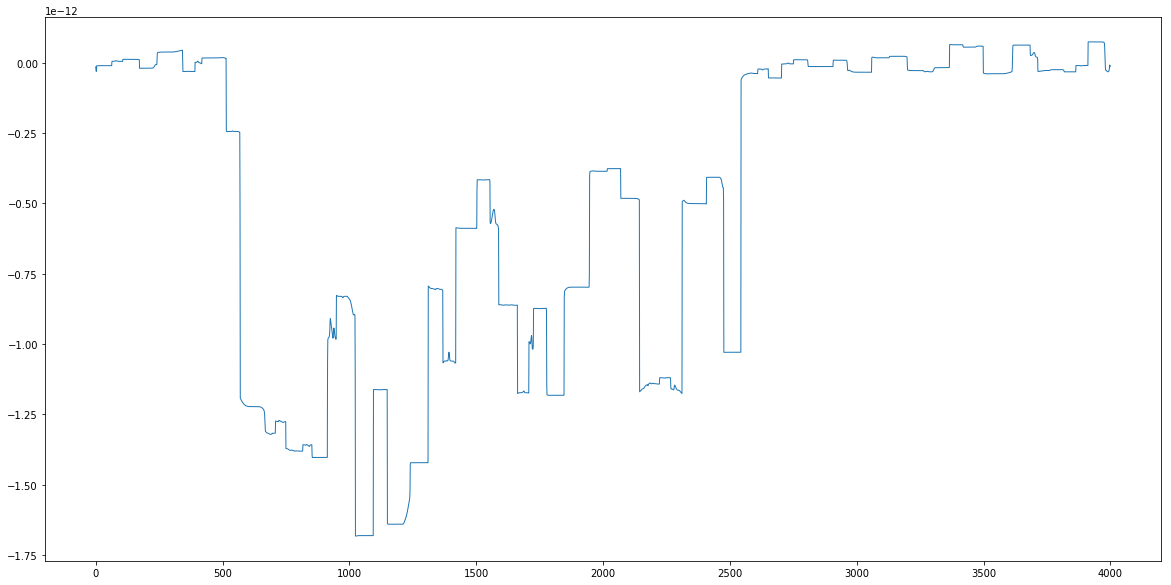

In [147]:
plt.figure(figsize=(20,10))
plt.plot(x,lw=1)
plt.show()

In [127]:
from analysis import multilevel_threshold, threshold_crossing

In [135]:
amps = -1e-12*np.array([.2,.35,.5,.9])
i = multilevel_threshold(trace,[.1,.3,.55,.85])

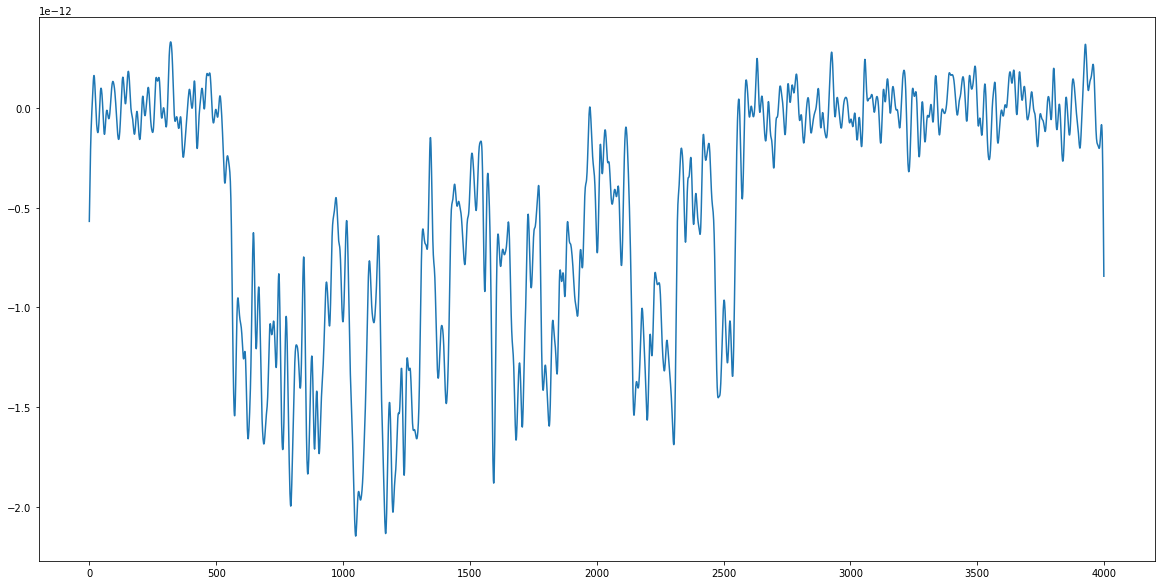

In [139]:
plt.figure(figsize=(20,10))
plt.plot(data['BC_BC_GFILTER1000.0_'][20].trace)
plt.show()

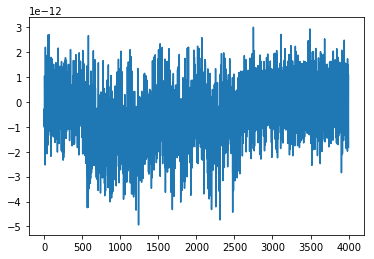

In [130]:
plt.plot(trace)
plt.show()

In [131]:
data.gauss_filter_series(1e3)

True

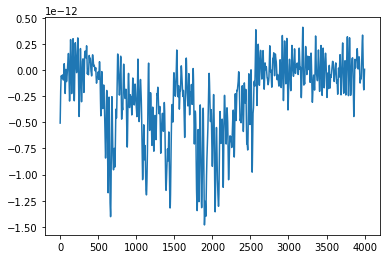